In [1]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from numba import cuda

In [2]:
def mass_search_CPU(N: np.ndarray, H: np.ndarray, R: np.ndarray):
  for j in range(R.shape[1]):
    for i in range(R.shape[0]):
      n = N[i]
      for k in range(len(n)):
        if n[k] == H[j]:
          R[i, j - k] -= 1
  return R

In [3]:
@cuda.jit
def mass_search_GPU(N: np.ndarray, H: np.ndarray, R: np.ndarray):
	# Получение асболютного значения индекса потока в сетке
	x, y = cuda.grid(2)
	# Рассматриваем каждый символ подстроки
	for k in range(N.shape[1]):
		# Декремент, если символ подстроки совпал с символом входного буффера
		if N[y, k] == H[x]:
				R[y, x - k] -= 1
	cuda.syncthreads()

In [4]:
def save_result(pathfile: str, N: np.ndarray, H: np.ndarray, 
                result: np.ndarray, mode='a', sheet_name=''):
  """
  СОХРАНЕНИЕ РЕЗУЛЬТАТОВ ПОИСКА ПОДСТРОК.
  """
  
  # Для одиннаковой размерности данных result дополняется нулями.
  N_i = np.full(len(H), fill_value=None)
  position = np.full(len(H), fill_value=None)
  N_i[:len(result[0])] = result[0]
  position[:len(result[1])] = result[1]

  # Приведение списка символов (подстроки) к типу str
  # для корректной записи в excel
  new_N = [str(n) for n in N]
  # Создание DataFrame
  df = pd.DataFrame({"N": new_N, "H": H, "N_i": N_i, 
                     "Position": position})
  # Если sheet_name не указан, то ставится дефолтное значение длины N
  if sheet_name == '':
    sheet_name = str(len(N))
  
  # Если стоит mode='a', то первая запись в файл выдаст ошибку,
  # поэтому в этом случае mode меняется на 'w'.
  try:
    with pd.ExcelWriter(pathfile, mode=mode) as writer:
      df.to_excel(writer, sheet_name=sheet_name)
  except:
    with pd.ExcelWriter(pathfile, mode='w') as writer:
      df.to_excel(writer, sheet_name=sheet_name)

In [5]:
sizes = np.arange(160, 1600, 160) # Размерности N и H (160, 320, ..., 1440)
i = 10                            # Кол-во итераций для подсчёта среднего времени
N_chars = 2                       # Кол-во символов в подстроках
BLOCK_DIM = 16                    # Размерность оси квадратного блока
BLOCK_SIZE = (BLOCK_DIM, BLOCK_DIM)

alp = np.arange(256)

df = {"Длина N":sizes,
      "Длина H":sizes,
      "Время на GPU":np.zeros(len(sizes), dtype=float), 
      "Время на CPU":np.zeros(len(sizes), dtype=float),
      "Соотношение CPU/GPU":np.zeros(len(sizes), dtype=float),
      "Одинаковые ли значения?":np.full(len(sizes), fill_value=True)}

df = pd.DataFrame(df, index=sizes)

# Вычисления для разных размерностей N и H
for size in sizes:

  # Случайная генерация подстрок N и входного буффера H
  N = np.random.randint(len(alp), size=(size, N_chars), dtype=np.uint8)
  H = np.random.randint(len(alp), size=size, dtype=np.uint8)

  # Заполнение рабочей матрицы NxH значениями N_chars
  R = np.full((size, size), fill_value=N_chars)

  # Инициализация сетки блоков
  GRID_SIZE = (len(N) // BLOCK_DIM, len(H) // BLOCK_DIM)

  # Суммы общего времени за определённое кол-во итераций для реализации
  gpu_common_time = []
  cpu_common_time = []

  # Выполнение одних и тех же вычислений для нахождения среднего времени
  for _ in range(i + 1):

    #Вычисление времени на GPU
    start_time = time()
    
    # Пересылка данных на устройство
    dev_N = cuda.to_device(N)
    dev_H = cuda.to_device(H)
    dev_R = cuda.to_device(R)
    
    # Запуск вычислений на GPU
    mass_search_GPU[GRID_SIZE, BLOCK_SIZE](dev_N, dev_H, dev_R)

    # Копирование рабочей матрицы с устройства на хост
    host_R = dev_R.copy_to_host()
    gpu_common_time.append(time() - start_time)

    #Вычисление времени на CPU
    start_time = time()
    R = mass_search_CPU(N, H, R.copy())
    cpu_common_time.append(time() - start_time)
  
  # Запись подсчётов времени и соответствия рабочих матриц
  df.loc[size, "Время на GPU"] = np.mean(gpu_common_time[1:])
  df.loc[size, "Время на CPU"] = np.mean(cpu_common_time[1:])
  df.loc[size, "Одинаковые ли значения?"] = np.array_equal(host_R, R)

  # Получение списка найденных подстрок
  result = np.array(np.where(host_R == 0))

  # Сохранение результатов в файл с несколькими листами
  save_result("found_substrings.xlsx", N, H, result, sheet_name=f'Размер {size}')
  print(f"Результаты поиска {size} успешно сохранены")

# Запись значений ускорения GPU над CPU
df["Соотношение CPU/GPU"] = df["Время на CPU"] / df["Время на GPU"]
# Вывод результатов на экран
df

/usr/local/lib/python3.8/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 100 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Результаты поиска 160 успешно сохранены
Результаты поиска 320 успешно сохранены
Результаты поиска 480 успешно сохранены
Результаты поиска 640 успешно сохранены
Результаты поиска 800 успешно сохранены
Результаты поиска 960 успешно сохранены
Результаты поиска 1120 успешно сохранены
Результаты поиска 1280 успешно сохранены
Результаты поиска 1440 успешно сохранены


,Длина N,Длина H,Время на GPU,Время на CPU,Соотношение CPU/GPU,Одинаковые ли значения?
160,160,160,0.001286,0.019423,15.106683,True
320,320,320,0.002216,0.080145,36.161361,True
480,480,480,0.002817,0.183846,65.261671,True
640,640,640,0.004270,0.452268,105.922273,True
800,800,800,0.004692,0.508381,108.351059,True
960,960,960,0.005973,0.842903,141.115974,True
1120,1120,1120,0.007223,1.168823,161.827899,False
1280,1280,1280,0.007839,1.457646,185.950518,True
1440,1440,1440,0.009350,2.146797,229.614782,False


<AxesSubplot:title={'center':'Сравнение времени вычислений'}, xlabel='Длина N', ylabel='Время, с'>

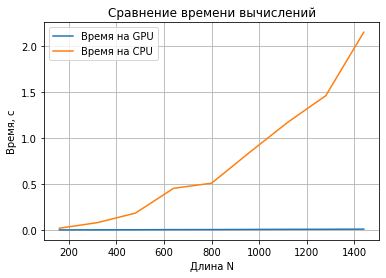

In [6]:
df.plot(x="Длина N", y=["Время на GPU", "Время на CPU"], 
        legend=True, grid=True,
        title="Сравнение времени вычислений",
        xlabel="Длина N", ylabel="Время, с")

array([<AxesSubplot:xlabel='Длина N', ylabel='Соотношение CPU/GPU'>],
      dtype=object)

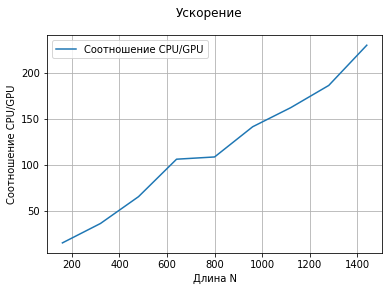

In [7]:
df.plot(x="Длина N", y="Соотношение CPU/GPU", 
        legend=True, grid=True, subplots=True, 
        title="Ускорение",
        xlabel="Длина N", ylabel="Соотношение CPU/GPU")